In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!cp -R /content/drive/MyDrive/Pokemon_data/df_pk_1.pkl /content
!cp /content/drive/MyDrive/Pokemon_data/samples.pkl ./
!cp /content/drive/MyDrive/Pokemon_data/Pokemon_matchups_V2.csv ./

In [44]:
%pip install pandas==1.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Subtract
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
np.random.seed(123)

In [6]:
df_pk = pd.read_pickle('/content/df_pk_1.pkl')
samples = pd.read_pickle('/content/samples.pkl')
battles = pd.read_csv('/content/Pokemon_matchups_V2.csv')

In [7]:
poke_names = list(df_pk['name_x'].unique())

In [8]:
X = tf.zeros([1, 167, 110], tf.int64)

for poke in poke_names:
  if poke != 'mew':
    idx = df_pk[df_pk['name_x'] == poke].index
    pkmn = samples.loc[idx]
    pkmn = pkmn.astype(int)
    pkmn.iloc[:, 30] = pkmn.iloc[:, 30] + 50
    pkmn.iloc[:, 32] = pkmn.iloc[:, 32] + 33
    pkmn = tf.reshape(pkmn, (1, -1, 110))
    pkmn = tf.concat([pkmn, tf.zeros([1, 167-pkmn.shape[1], 110], tf.int64)], axis=1)
  else:
    pkmn = tf.zeros([1, 167, 110], tf.int64)

  X = tf.concat([X, pkmn], axis=0)

In [9]:
X.shape

TensorShape([1216, 167, 110])

In [10]:
del df_pk

# Inputs preparation

In [11]:
battles = pd.read_csv('/content/Pokemon_matchups_V2.csv')
battles = battles[['N_Pokemon_1', 'N_Pokemon_2', 'Winner']]
battles = battles.drop(battles[battles['N_Pokemon_1'] == 151].index)
battles = battles.drop(battles[battles['N_Pokemon_2'] == 151].index)
battles = battles[(battles['N_Pokemon_1'] <= 721) & (battles['N_Pokemon_2'] <= 721)]
idx_train = battles.index
battles

,N_Pokemon_1,N_Pokemon_2,Winner
0,1,617,1
1,2,168,1
2,3,267,0
3,3,15,0
5,5,412,0
...,...,...,...
18509,396,16,0
18510,445,248,0
18511,252,114,1
18512,253,212,1


In [12]:
in_1 = battles.apply(lambda row: X[row['N_Pokemon_1'], :, :].numpy(), axis=1)
in_1 = np.stack(in_1, axis=0)

in_2 = battles.apply(lambda row: X[row['N_Pokemon_2'], :, :].numpy(), axis=1)
in_2 = np.stack(in_2, axis=0)

labels = np.array(battles['Winner'])

In [13]:
del X
del pkmn
del samples
del battles

# Model

In [14]:
input_tensor_emb = Input((167, 110))
layer_1_emb = Embedding(input_dim=256,
                        output_dim=16)(input_tensor_emb)
layer_2_emb = Flatten()(layer_1_emb)
emb_model = Model(input_tensor_emb, layer_2_emb, name='Embedding_Model')

pkmn_input_1 = Input((167, 110), name='Input_Pokemon_1')
pkmn_input_2 = Input((167, 110), name='Input_Pokemon_2')

layer_pkmn_1 = emb_model(pkmn_input_1)
layer_pkmn_2 = emb_model(pkmn_input_2)
subtract = Subtract()([layer_pkmn_1, layer_pkmn_2])
layer_3 = Dense(16, activation='relu', name='Dense')(subtract)
out_layer = Dense(1, activation='sigmoid', name='Output')(layer_3)

model = Model([pkmn_input_1, pkmn_input_2], out_layer, name='Battle_Model')

In [15]:
model.summary()

Model: "Battle_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Pokemon_1 (InputLayer)   [(None, 167, 110)]   0           []                               
                                                                                                  
 Input_Pokemon_2 (InputLayer)   [(None, 167, 110)]   0           []                               
                                                                                                  
 Embedding_Model (Functional)   (None, 293920)       4096        ['Input_Pokemon_1[0][0]',        
                                                                  'Input_Pokemon_2[0][0]']        
                                                                                                  
 subtract (Subtract)            (None, 293920)       0           ['Embedding_Model[0][0

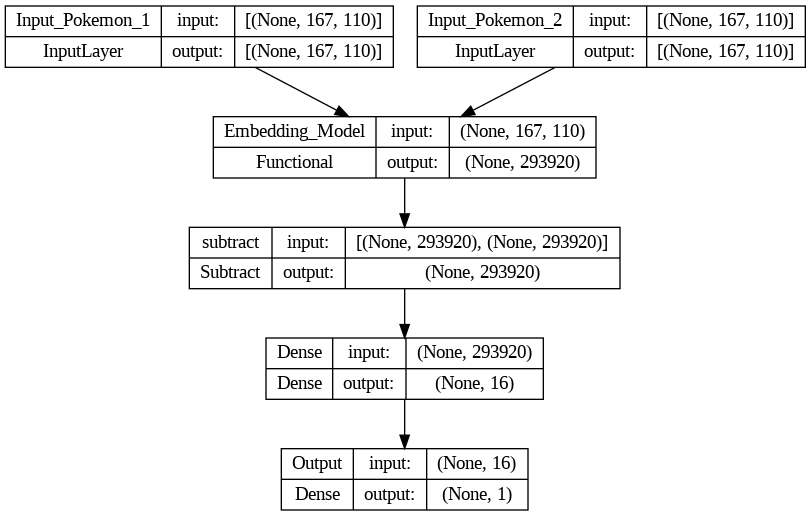

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
early_stopping_monitor = EarlyStopping(patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit([in_1, in_2], labels, epochs=10, validation_split=0.2,
          callbacks=[early_stopping_monitor])

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


302/302 [==============================] - 43s 141ms/step - loss: 0.3154 - accuracy: 0.8551 - val_loss: 0.3407 - val_accuracy: 0.8425
Epoch 2/10
302/302 [==============================] - 44s 146ms/step - loss: 0.2182 - accuracy: 0.9071 - val_loss: 0.3416 - val_accuracy: 0.8507
Epoch 3/10
302/302 [==============================] - 43s 142ms/step - loss: 0.1825 - accuracy: 0.9223 - val_loss: 0.3578 - val_accuracy: 0.8541
Epoch 4/10
302/302 [==============================] - 42s 140ms/step - loss: 0.1640 - accuracy: 0.9283 - val_loss: 0.3745 - val_accuracy: 0.8524


In [19]:
np.save('/content/drive/MyDrive/Pokemon_data/idx_train.npy', idx_train)
model.save('/content/drive/MyDrive/Pokemon_data/model')

# Prediction on new data

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!cp -R /content/drive/MyDrive/Pokemon_data/df_pk_1.pkl /content
!cp /content/drive/MyDrive/Pokemon_data/samples.pkl ./
!cp /content/drive/MyDrive/Pokemon_data/Pokemon_matchups_V2.csv ./
!cp /content/drive/MyDrive/Pokemon_data/idx_train.npy ./
!cp -r /content/drive/MyDrive/Pokemon_data/model ./

In [3]:
import pandas as pd
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Subtract
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
df_pk = pd.read_pickle('/content/df_pk_1.pkl')
samples = pd.read_pickle('/content/samples.pkl')
battles = pd.read_csv('/content/Pokemon_matchups_V2.csv')
model = tf.keras.models.load_model('model')

In [6]:
poke_names = list(df_pk['name_x'].unique())

In [7]:
X = tf.zeros([1, 167, 110], tf.int64)

for poke in poke_names:
  if poke != 'mew':
    idx = df_pk[df_pk['name_x'] == poke].index
    pkmn = samples.loc[idx]
    pkmn = pkmn.astype(int)
    pkmn.iloc[:, 30] = pkmn.iloc[:, 30] + 50
    pkmn.iloc[:, 32] = pkmn.iloc[:, 32] + 33
    pkmn = tf.reshape(pkmn, (1, -1, 110))
    pkmn = tf.concat([pkmn, tf.zeros([1, 167-pkmn.shape[1], 110], tf.int64)], axis=1)
  else:
    pkmn = tf.zeros([1, 167, 110], tf.int64)

  X = tf.concat([X, pkmn], axis=0)

In [8]:
del df_pk

# Test inputs preparation

In [9]:
battles = pd.read_csv('/content/Pokemon_matchups_V2.csv')
battles = battles[['N_Pokemon_1', 'N_Pokemon_2', 'Winner']]
battles = battles.drop(battles[battles['N_Pokemon_1'] == 151].index)
battles = battles.drop(battles[battles['N_Pokemon_2'] == 151].index)
battles = battles[(battles['N_Pokemon_1'] > 721) | (battles['N_Pokemon_2'] > 721)]
battles

,N_Pokemon_1,N_Pokemon_2,Winner
4,4,824,0
7,6,794,0
10,8,737,1
13,10,742,1
14,11,825,1
...,...,...,...
18501,889,60,0
18502,890,61,0
18503,890,62,0
18506,25,877,1


In [10]:
in_1 = battles.apply(lambda row: X[row['N_Pokemon_1'], :, :].numpy(), axis=1)
in_1 = np.stack(in_1, axis=0)

in_2 = battles.apply(lambda row: X[row['N_Pokemon_2'], :, :].numpy(), axis=1)
in_2 = np.stack(in_2, axis=0)

labels = np.array(battles['Winner'])

# Model Test

In [11]:
model = tf.keras.models.load_model('model')

In [12]:
model.evaluate([in_1, in_2], labels)[1]

  3/201 [..............................] - ETA: 7s - loss: 0.4776 - accuracy: 0.8542 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


201/201 [==============================] - 7s 36ms/step - loss: 0.3658 - accuracy: 0.8636


0.8636363744735718

In [13]:
predictions = model.predict([in_1, in_2])

201/201 [==============================] - 7s 36ms/step


In [14]:
conf_matrix = tf.math.confusion_matrix(labels, np.round(predictions))
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[3819,  549],
       [ 327, 1729]], dtype=int32)>

In [15]:
conf_matrix.numpy()

array([[3819,  549],
       [ 327, 1729]], dtype=int32)

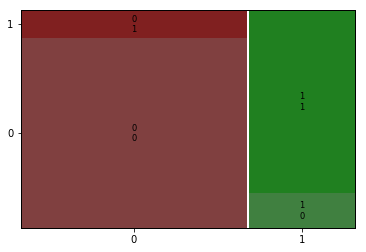

In [18]:
mosaic(conf_matrix.numpy())
plt.show()